In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/ECSE 552 Project

/content/drive/MyDrive/Colab Notebooks/ECSE 552 Project


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Concatenate, Input, BatchNormalization
import h5py
import gc
import matplotlib.pyplot as plt

# Feature Engineering

In [ ]:
# Load data
train_data = pd.read_parquet('parquet_data/train.parquet')
test_data = pd.read_parquet('parquet_data/test.parquet')
train_labels = pd.read_csv('data/train_labels.csv')

In [ ]:
# Merge train_data and train_labels
train_data = train_data.merge(train_labels, on='customer_ID', how='left')

In [ ]:
def feature_engineer(df):
    # REDUCE STRING COLUMNS
    df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')
    df['S_2'] = pd.to_datetime(df['S_2'])
    df['year'] = df['S_2'].dt.year.astype('int16')
    df['month'] = df['S_2'].dt.month.astype('int8')
    df['day'] = df['S_2'].dt.day.astype('int8')
    df = df.drop(['S_2'], axis=1)

    # LABEL ENCODE CAT COLUMNS
    d_63_map = {'CL': 2, 'CO': 3, 'CR': 4, 'XL': 5, 'XM': 6, 'XZ': 7}
    df['D_63'] = df['D_63'].map(d_63_map).fillna(1).astype('int8')

    d_64_map = {'-1': 2, 'O': 3, 'R': 4, 'U': 5}
    df['D_64'] = df['D_64'].map(d_64_map).fillna(1).astype('int8')

    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [2, 1, 2, 2, 3, 2, 3, 2, 2]
    for c, s in zip(CATS, OFFSETS):
        df[c] = df[c] + s
        df[c] = df[c].fillna(1).astype('int8')
    CATS += ['D_63', 'D_64']

    # REDUCE MEMORY USAGE
    SKIP = ['customer_ID', 'year', 'month', 'day', 'target']
    for c in df.columns:
        if c in SKIP:
            continue
        if str(df[c].dtype) == 'int64':
            df[c] = df[c].astype('int32')
        if str(df[c].dtype) == 'float64':
            df[c] = df[c].astype('float32')

    # FILLNA
    df = df.fillna(-0.5)

    # SORT BY CUSTOMER AND DATE
    df = df.sort_values(['customer_ID', 'year', 'month', 'day']).reset_index(drop=True)
    df = df.drop(['year', 'month', 'day'], axis=1)

    # REARRANGE COLUMNS WITH 11 CATS FIRST
    COLS = list(df.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    df = df[COLS]

    return df

In [ ]:
train_data = feature_engineer(train_data)

In [ ]:
test_data = feature_engineer(test_data)

In [ ]:
train_data.to_parquet('parquet_data/train_fe.parquet')
test_data.to_parquet('parquet_data/test_fe.parquet')

# Group Data to 3D Array



In [4]:
train_data = pd.read_parquet('parquet_data/train_fe.parquet')

In [5]:
# Drop target
train_data = train_data.drop('target', axis=1)

# Group by customer_ID
train_grouped = train_data.groupby('customer_ID')

# Initialize an empty array to store the 3D data
train_data_3d = np.zeros((len(train_grouped), 13, train_data.shape[1] - 1))

# Iterate over groups and populate the 3D array
for i, (_, group) in tqdm(enumerate(train_grouped), total=len(train_grouped)):
    group = group.drop('customer_ID', axis=1).values
    padding_length = 13 - len(group)
    if padding_length > 0:
        group = np.concatenate([group, np.zeros((padding_length, group.shape[1]))])
    train_data_3d[i] = group[:13]

100%|██████████| 458913/458913 [04:43<00:00, 1621.29it/s]


In [ ]:
test_data = pd.read_parquet('parquet_data/test_fe.parquet')

In [ ]:
# Group by customer_ID
test_grouped = test_data.groupby('customer_ID')

# Initialize an empty array to store the 3D data
test_data_3d = np.zeros((len(test_grouped), 13, test_data.shape[1] - 1))

# Iterate over groups and populate the 3D array
for i, (_, group) in tqdm(enumerate(test_grouped), total=len(test_grouped)):
    group = group.drop('customer_ID', axis=1).values
    padding_length = 13 - len(group)
    if padding_length > 0:
        group = np.concatenate([group, np.zeros((padding_length, group.shape[1]))])
    test_data_3d[i] = group[:13]

100%|██████████| 924621/924621 [09:53<00:00, 1558.88it/s]


In [ ]:
# Save the datasets into a HDF5 file
with h5py.File('parquet_data/array_datasets.h5', 'w') as hf:
    hf.create_dataset('train', data=train_data_3d)
    hf.create_dataset('test', data=test_data_3d)

# Normalization

In [ ]:
with h5py.File('parquet_data/array_datasets.h5', 'r') as hf:
    train_data_3d = hf['train'][:]
    test_data_3d = hf['test'][:]

In [7]:
# Normalize train_data_3d
train_data_3d[:, :13, 11:] = (train_data_3d[:, :13, 11:] - np.mean(train_data_3d[:, :13, 11:], axis=(0, 1))) / np.std(train_data_3d[:, :13, 11:], axis=(0, 1))

In [4]:
with h5py.File('parquet_data/array_datasets.h5', 'r') as hf:
    test_data_3d = hf['test'][:]

In [5]:
# Normalize test_data_3d
test_data_3d[:, :, 11:] = (test_data_3d[:, :, 11:] - np.mean(test_data_3d[:, :, 11:], axis=(0, 1))) / np.std(test_data_3d[:, :, 11:], axis=(0, 1))

In [ ]:
# Calculate mean and standard deviation based on train data
train_mean = np.mean(train_data_3d[:, :, 11:], axis=(0, 1))
train_std = np.std(train_data_3d[:, :, 11:], axis=(0, 1))

# Normalize train_data_3d
train_data_3d[:, :, 11:] = (train_data_3d[:, :, 11:] - train_mean) / train_std

# Normalize test_data_3d using train data's mean and standard deviation
test_data_3d[:, :, 11:] = (test_data_3d[:, :, 11:] - train_mean) / train_std

In [ ]:
# Calculate the minimum and maximum values based on train data
train_min = np.min(train_data_3d[:, :, 11:], axis=(0, 1))
train_max = np.max(train_data_3d[:, :, 11:], axis=(0, 1))

# Ensure train_max - train_min is not zero to avoid division by zero
epsilon = 1e-10
train_range = np.where(train_max - train_min == 0, epsilon, train_max - train_min)

# Apply min-max scaling to train_data_3d
train_data_3d[:, :, 11:] = (train_data_3d[:, :, 11:] - train_min) / train_range

# Apply min-max scaling to test_data_3d using train data's min and max
test_data_3d[:, :, 11:] = (test_data_3d[:, :, 11:] - train_min) / train_range

# Build and Train Model

In [9]:
def build_model(input_shape):
    # Define the input layers
    input_cat = [Input(shape=(input_shape[1],), dtype='int32') for _ in range(11)]
    input_num = Input(shape=(input_shape[1], input_shape[2] - 11))

    # Embedding layers for categorical features
    embeddings = []
    for i in range(11):
        embedding = Embedding(10, 8)(input_cat[i])
        embeddings.append(embedding)

    # Concatenate numerical features and embeddings
    concat = Concatenate(axis=-1)(embeddings + [input_num])

    # GRU layers
    gru = GRU(units=128, return_sequences=False)(concat)
    gru = BatchNormalization()(gru)
    gru = Dropout(0.3)(gru)

    # Dense layers
    dense1 = Dense(64, activation='relu')(gru)
    dense1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(32, activation='relu')(dropout1)
    dense2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.5)(dense2)

    # Output layer
    output = Dense(1, activation='sigmoid')(dropout2)

    # Compile the model
    model = tf.keras.Model(inputs=input_cat + [input_num], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [9]:
# Custom Learning rate Schedule
def custom_lr(epoch):
    lr = [1e-3]*5 + [1e-4]*2 + [1e-5]*1
    return lr[epoch]
LR = tf.keras.callbacks.LearningRateScheduler(custom_lr, verbose=False)

In [10]:
# Prepare the target variable
train_data = pd.read_parquet('parquet_data/train_fe.parquet')
train_target = train_data.groupby('customer_ID')['target'].mean().values

In [11]:
# Define the number of folds for cross-validation
n_splits = 5

# Create a dictionary to store the training and validation losses for each fold and epoch
losses = {}

# Create the StratifiedKFold object
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_data_3d, train_target)):
    # Split the data into training and validation sets for the current fold
    X_train, X_valid = train_data_3d[train_idx], train_data_3d[valid_idx]
    y_train, y_valid = train_target[train_idx], train_target[valid_idx]

    # Prepare the input data
    train_cat = X_train[:, :, :11].astype(int)
    train_num = X_train[:, :, 11:]
    train_inputs = [train_cat[:, :, i] for i in range(11)] + [train_num]

    val_cat = X_valid[:, :, :11].astype(int)
    val_num = X_valid[:, :, 11:]
    val_inputs = [val_cat[:, :, i] for i in range(11)] + [val_num]

    # BUILD AND TRAIN MODEL
    tf.keras.backend.clear_session()
    model = build_model(X_train.shape)
    history = model.fit(train_inputs, y_train,
              validation_data=(val_inputs, y_valid),
              batch_size=512, epochs=8, verbose=2,
              callbacks=[LR])

    model.save_weights(f'model/gru_std_norm_fold_{fold + 1}_weights.h5')

    # Record the training and validation losses for each epoch in the current fold
    losses[fold + 1] = {
        'train_loss': history.history['loss'],
        'valid_loss': history.history['val_loss']
    }

    # CLEAN MEMORY
    del model, train_inputs, val_inputs
    gc.collect()

Epoch 1/8
718/718 - 20s - loss: 0.3082 - accuracy: 0.8735 - val_loss: 0.2345 - val_accuracy: 0.8973 - lr: 0.0010 - 20s/epoch - 28ms/step
Epoch 2/8
718/718 - 8s - loss: 0.2452 - accuracy: 0.8928 - val_loss: 0.2273 - val_accuracy: 0.8992 - lr: 0.0010 - 8s/epoch - 12ms/step
Epoch 3/8
718/718 - 9s - loss: 0.2372 - accuracy: 0.8957 - val_loss: 0.2247 - val_accuracy: 0.9002 - lr: 0.0010 - 9s/epoch - 12ms/step
Epoch 4/8
718/718 - 9s - loss: 0.2332 - accuracy: 0.8985 - val_loss: 0.2235 - val_accuracy: 0.9018 - lr: 0.0010 - 9s/epoch - 12ms/step
Epoch 5/8
718/718 - 9s - loss: 0.2303 - accuracy: 0.8997 - val_loss: 0.2241 - val_accuracy: 0.9012 - lr: 0.0010 - 9s/epoch - 12ms/step
Epoch 6/8
718/718 - 8s - loss: 0.2248 - accuracy: 0.9028 - val_loss: 0.2214 - val_accuracy: 0.9023 - lr: 1.0000e-04 - 8s/epoch - 12ms/step
Epoch 7/8
718/718 - 9s - loss: 0.2232 - accuracy: 0.9029 - val_loss: 0.2211 - val_accuracy: 0.9026 - lr: 1.0000e-04 - 9s/epoch - 12ms/step
Epoch 8/8
718/718 - 8s - loss: 0.2218 - accur

In [14]:
# Calculate the average training and validation losses per epoch across all folds
avg_train_losses = []
avg_valid_losses = []
num_epochs = 8

for epoch in range(num_epochs):
    train_losses_epoch = [losses[fold]['train_loss'][epoch] for fold in losses]
    valid_losses_epoch = [losses[fold]['valid_loss'][epoch] for fold in losses]

    avg_train_loss = sum(train_losses_epoch) / n_splits
    avg_valid_loss = sum(valid_losses_epoch) / n_splits

    avg_train_losses.append(avg_train_loss)
    avg_valid_losses.append(avg_valid_loss)

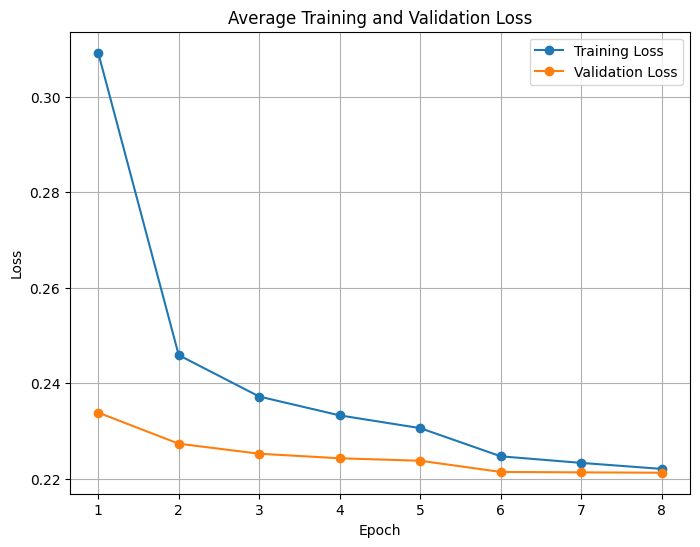

In [16]:
# Plot the average training and validation losses per epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, avg_train_losses, marker='o', label='Training Loss')
plt.plot(epochs, avg_valid_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make Predictions

In [6]:
# Split test data into categorical and numerical features
test_cat = test_data_3d[:, :, :11].astype(int)
test_num = test_data_3d[:, :, 11:]

In [7]:
# Prepare the input data
test_inputs = [test_cat[:, :, i] for i in range(11)] + [test_num]

In [10]:
# List to store the predictions from each model
ensemble_predictions = []

# Iterate over the 5 models
for fold in range(1, 6):
    # Load the model
    model = build_model(test_data_3d.shape)
    model.load_weights(f'model/gru_std_norm_fold_{fold}_weights.h5')

    # Make predictions on the test data
    fold_predictions = model.predict(test_inputs, batch_size=512, verbose=2).flatten()
    ensemble_predictions.append(fold_predictions)

    # Clean up the model to free memory
    del model
    gc.collect()

1806/1806 - 9s - 9s/epoch - 5ms/step
1806/1806 - 8s - 8s/epoch - 5ms/step
1806/1806 - 8s - 8s/epoch - 5ms/step
1806/1806 - 8s - 8s/epoch - 5ms/step
1806/1806 - 8s - 8s/epoch - 5ms/step


In [11]:
# Calculate the ensemble predictions by averaging the predictions from all models
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Create Submission

In [12]:
submission_df = pd.read_csv('data/sample_submission.csv')

In [13]:
submission_df.drop('prediction', axis=1)

,customer_ID
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...
...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...


In [14]:
# Create a temporary column for sorting
submission_df['customer_ID_int64'] = submission_df['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')

# Sort the DataFrame based on the temporary column
submission_df = submission_df.sort_values(by='customer_ID_int64').reset_index(drop=True)

# Drop the temporary column
submission_df = submission_df.drop(columns=['customer_ID_int64'])

In [15]:
submission_df['prediction'] = ensemble_predictions

In [16]:
# Save the DataFrame to a CSV file
submission_df.to_csv('predictions.csv', index=False)